In [1]:
# import data
!wget https://nlp100.github.io/data/ai.ja.zip
!unzip ai.ja.zip

--2023-05-25 15:25:58--  https://nlp100.github.io/data/ai.ja.zip
Resolving nlp100.github.io (nlp100.github.io)... 185.199.108.153, 185.199.111.153, 185.199.110.153, ...
Connecting to nlp100.github.io (nlp100.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17516 (17K) [application/zip]
Saving to: ‘ai.ja.zip’

ai.ja.zip           100%[===================>]  17.11K  --.-KB/s    in 0.001s  

2023-05-25 15:25:58 (14.6 MB/s) - ‘ai.ja.zip’ saved [17516/17516]

Archive:  ai.ja.zip
  inflating: ai.ja.txt               
  inflating: readme.ai.ja.md         


In [6]:
# Mecab installation
! brew install mecab
! brew install mecab-ipadic
! pip install mecab-python3

# CaboCha installation
! brew install crf++
! brew install cabocha

To reinstall 0.996, run:
  brew reinstall mecab
To reinstall 2.7.0-20070801, run:
  brew reinstall mecab-ipadic
     |████████████████████████████████| 77 kB 4.1 MB/s eta 0:00:01
Using legacy 'setup.py install' for mecab-python3, since package 'wheel' is not installed.
    Running setup.py install for mecab-python3 ... done
You should consider upgrading via the '/Users/dothaidon/.pyenv/versions/3.9.2/bin/python3.9 -m pip install --upgrade pip' command.
==> Fetching crf++
==> Downloading https://ghcr.io/v2/homebrew/core/crfxx/manifests/0.58-3
######################################################################### 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/crfxx/blobs/sha256:b2ace94562fd
==> Downloading from https://pkg-containers.githubusercontent.com/ghcr1/blobs/sh
######################################################################### 100.0%
==> Pouring crf++--0.58.arm64_ventura.bottle.3.tar.gz
🍺  /opt/homebrew/Cellar/crf++/0.58: 11 files, 650.1KB
==> Running `brew cl

In [8]:
# Morphemes parsers
!cabocha -o ai.ja.txt.parsed -f1 -n1 ai.ja.txt
!head -15 ./ai.ja.txt.parsed


* 0 -1D 1/1 0.000000
人工	名詞,一般,*,*,*,*,人工,ジンコウ,ジンコー	O
知能	名詞,一般,*,*,*,*,知能,チノウ,チノー	O
EOS
EOS
* 0 17D 1/1 0.388993
人工	名詞,一般,*,*,*,*,人工,ジンコウ,ジンコー	O
知能	名詞,一般,*,*,*,*,知能,チノウ,チノー	O
* 1 17D 2/3 0.613549
（	記号,括弧開,*,*,*,*,（,（,（	O
じん	名詞,一般,*,*,*,*,じん,ジン,ジン	O
こうち	名詞,一般,*,*,*,*,こうち,コウチ,コーチ	O
のう	助詞,終助詞,*,*,*,*,のう,ノウ,ノー	O
、	記号,読点,*,*,*,*,、,、,、	O
、	記号,読点,*,*,*,*,、,、,、	O


In [16]:
class Morph:
    def __init__(self, morph):
        cols = morph.split('\t')
        attr = cols[1].split(',')
        self.surface = cols[0]
        self.base = attr[6]
        self.pos = attr[0]
        self.pos1 = attr[1]



sentences = []
morphs = []

with open('ai.ja.txt.parsed', 'r') as f:
    for line in f:
        if line.startswith('*'):
            continue
        elif line != 'EOS\n':
            morphs.append(Morph(line))
            sentences.append(morphs)
            morphs = []

for w in sentences[0]:
    print(vars(w))

{'surface': '人工', 'base': '人工', 'pos': '名詞', 'pos1': '一般'}
{'surface': '知能', 'base': '知能', 'pos': '名詞', 'pos1': '一般'}


In [36]:
class Chunk():
    def __init__(self, morphs, dst):
        self.morphs = morphs
        self.dst = dst
        self.srcs = []

class Sentence():
    def __init__(self, chunks):
        self.chunks = chunks
        for i, chunk in enumerate(self.chunks):
            # print(chunk.dst)
            if chunk.dst != -1:
                self.chunks[chunk.dst].srcs.append(i)

sentences = []
chunks = []
morphs = []

with open('ai.ja.txt.parsed', 'r') as f:
    for line in f:
        if line.startswith('*'):
            if len(morphs) > 0:
                chunks.append(Chunk(morphs, dst))
                morphs = []
            dst = int(line.split(' ')[2].strip('D'))
        elif line != 'EOS\n':
            morphs.append(Morph(line))
        else:
            chunks.append(Chunk(morphs, dst))
            sentences.append(Sentence(chunks))
            morphs = []
            chunks = []
            dst = -1

for chunk in sentences[2].chunks:
    print([morph.surface for morph in chunk.morphs], chunk.dst, chunk.srcs)

['人工', '知能'] 17 []
['（', 'じん', 'こうち', 'のう', '、', '、'] 17 []
['AI'] 3 []
['〈', 'エーアイ', '〉', '）', 'と', 'は', '、'] 17 [2]
['「', '『', '計算'] 5 []
['（', '）', '』', 'という'] 9 [4]
['概念', 'と'] 9 []
['『', 'コンピュータ'] 8 []
['（', '）', '』', 'という'] 9 [7]
['道具', 'を'] 10 [5, 6, 8]
['用い', 'て'] 12 [9]
['『', '知能', '』', 'を'] 12 []
['研究', 'する'] 13 [10, 11]
['計算', '機', '科学'] 14 [12]
['（', '）', 'の'] 15 [13]
['一', '分野', '」', 'を'] 16 [14]
['指す'] 17 [15]
['語', '。'] 34 [0, 1, 3, 16]
['「', '言語', 'の'] 20 []
['理解', 'や'] 20 []
['推論', '、'] 21 [18, 19]
['問題', '解決', 'など', 'の'] 22 [20]
['知的', '行動', 'を'] 24 [21]
['人間', 'に'] 24 []
['代わっ', 'て'] 26 [22, 23]
['コンピューター', 'に'] 26 []
['行わ', 'せる'] 27 [24, 25]
['技術', '」', '、', 'または', '、'] 34 [26]
['「', '計算', '機'] 29 []
['（', 'コンピュータ', '）', 'による'] 31 [28]
['知的', 'な'] 31 []
['情報処理', 'システム', 'の'] 33 [29, 30]
['設計', 'や'] 33 []
['実現', 'に関する'] 34 [31, 32]
['研究', '分野', '」', 'と', 'も'] 35 [17, 27, 33]
['さ', 'れる', '。'] -1 [34]


In [39]:
sentence = sentences[2]

for chunk in sentence.chunks:
    if chunk.dst != -1:
        src = ''.join(morph.surface for morph in chunk.morphs if morph.pos != '記号')
        dst = ''.join(morph.surface for morph in sentence.chunks[chunk.dst].morphs if morph.pos != '記号')
        print(src + '\t' + dst)

人工知能	語
じんこうちのう	語
AI	エーアイとは
エーアイとは	語
計算	という
という	道具を
概念と	道具を
コンピュータ	という
という	道具を
道具を	用いて
用いて	研究する
知能を	研究する
研究する	計算機科学
計算機科学	の
の	一分野を
一分野を	指す
指す	語
語	研究分野とも
言語の	推論
理解や	推論
推論	問題解決などの
問題解決などの	知的行動を
知的行動を	代わって
人間に	代わって
代わって	行わせる
コンピューターに	行わせる
行わせる	技術または
技術または	研究分野とも
計算機	コンピュータによる
コンピュータによる	情報処理システムの
知的な	情報処理システムの
情報処理システムの	実現に関する
設計や	実現に関する
実現に関する	研究分野とも
研究分野とも	される


In [41]:
sentence = sentences[2]

for chunk in sentence.chunks:
    if chunk.dst != -1:
        src = ''.join(morph.surface for morph in chunk.morphs if morph.pos != '記号')
        dst = ''.join(morph.surface for morph in sentence.chunks[chunk.dst].morphs if morph.pos != '記号')
        src_pos = [morph.pos for morph in chunk.morphs]
        dst_pos = [morph.pos for morph in sentence.chunks[chunk.dst].morphs]
        if '名詞' in src_pos and '動詞' in dst_pos:
            print(src + '\t' + dst)

道具を	用いて
知能を	研究する
一分野を	指す
知的行動を	代わって
人間に	代わって
コンピューターに	行わせる
研究分野とも	される


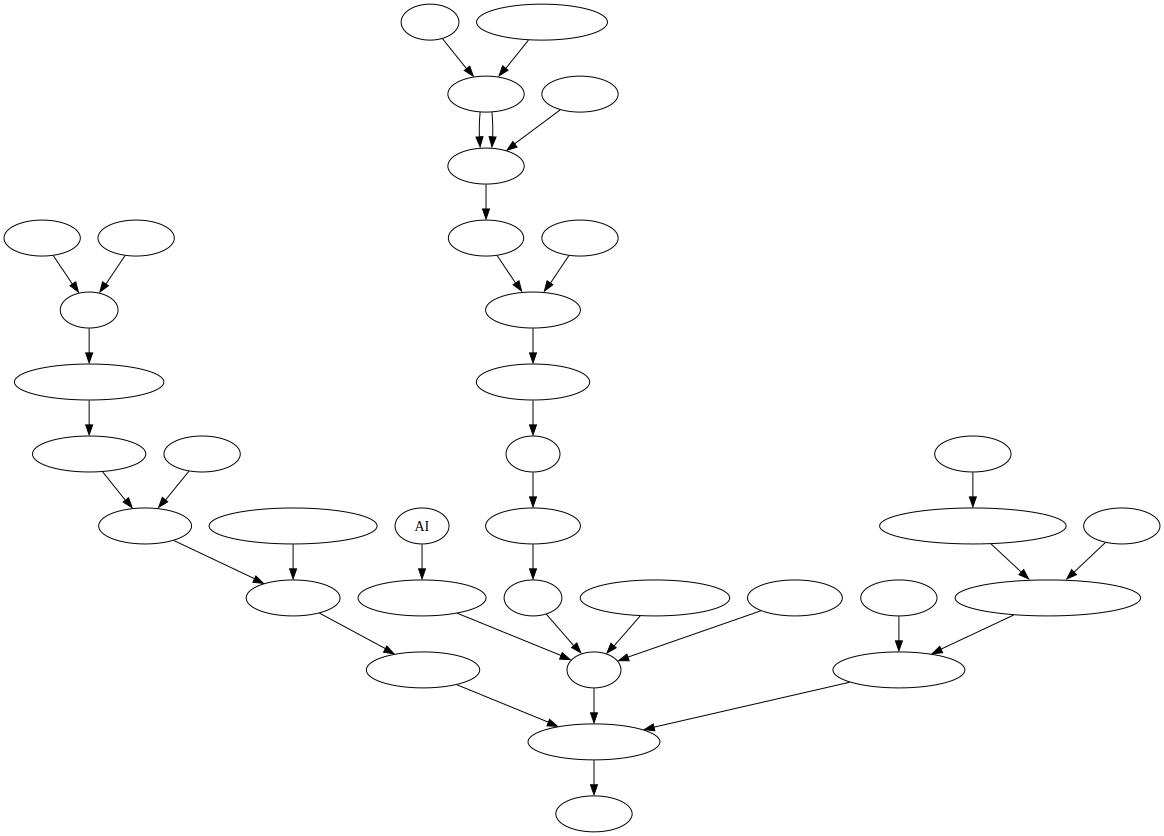

In [57]:
sentence = sentences[2]

# !pip install graphviz
# !brew install graphviz

import graphviz

dot = graphviz.Digraph()

for chunk in sentence.chunks:
    if chunk.dst != -1:
        src = ''.join(morph.surface for morph in chunk.morphs if morph.pos != '記号')
        dst = ''.join(morph.surface for morph in sentence.chunks[chunk.dst].morphs if morph.pos != '記号')
        dot.node(src)
        dot.node(dst)
        dot.edge(src, dst)
    
dot

In [87]:
with open("out45.txt", "w") as f:
    for sentence in sentences:
        for chunk in sentence.chunks:
            for morph in chunk.morphs:
                if morph.pos == '動詞':
                    particles = []
                    for src in chunk.srcs:
                        particles = particles + [morph.surface for morph in sentence.chunks[src].morphs if morph.pos == '助詞']
                    if len(particles) > 0:
                        line = morph.base + '\t' + ' '.join(sorted(list(set(particles))))
                        print(line, file = f)
                    break

In [88]:
!cat out45.txt | sort | uniq -c | sort -nr | head -n 10

  49 する	を
  19 する	が
  15 する	に
  15 する	と
  12 する	は を
  10 する	に を
   9 よる	に
   9 する	で を
   8 行う	を
   8 する	が に


In [89]:
!cat out45.txt | grep '行う' | sort | uniq -c | sort -nr | head -n 10

   8 行う	を
   1 行う	まで を
   1 行う	は を をめぐって
   1 行う	は を
   1 行う	に を
   1 行う	に まで を
   1 行う	に により を
   1 行う	に
   1 行う	で を
   1 行う	で に を


In [90]:
!cat out45.txt | grep 'なる' | sort | uniq -c | sort -nr | head -n 10

   3 なる	に は
   3 なる	が と
   2 なる	に
   2 なる	と
   1 異なる	も
   1 異なる	が で
   1 無くなる	は
   1 なる	も
   1 なる	は
   1 なる	に は も


In [91]:
!cat out45.txt | grep '与える' | sort | uniq -c | sort -nr | head -n 10

   1 与える	に は を
   1 与える	が に
   1 与える	が など に
